In [1]:
#import the reuired packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.python.keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adamax, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

#initialise random number seed
np.random.seed(2)


In [2]:
#read the train and test data
train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")

In [3]:
#Store and remove the target for the train dataset 
Y_train = train["label"]

X_train = train.drop(labels = ["label"],axis = 1) 

#g = sns.countplot(Y_train)
#Y_train.value_counts()

In [4]:
#Check for null or wrong values in the dataset 

X_train.isnull().any().describe()
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [5]:
#Normalise the Data
X_train = X_train / 255.0
test = test / 255.0

In [6]:
#Reshape data to get 3-D image
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [7]:
Y_train = to_categorical(Y_train, num_classes = 10)

In [8]:
#Split data for training and validation
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

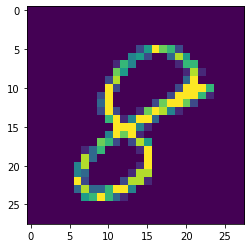

In [9]:
g = plt.imshow(X_train[0][:,:,0])
#X_train[0]

In [10]:
#set the CNN model
#model summary at the bottom 


model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
#model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
#model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
#model.add(BatchNormalization())
model.add(Dense(256, activation = "relu"))
#model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

In [11]:
#Define and complie Optimizer

optimizer = Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
#optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [13]:
#Data Augmentation to improve accuracy

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=True,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

D:\MiniConda\envs\tensorflow\lib\site-packages\keras_preprocessing\image\image_data_generator.py:355: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [14]:
#Fit the model, validating the model alongside.
#tap_model is model history, can be used to plot loss and accuracy curves for training and validation 
tap_model = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=128),epochs = 30, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // 128)

Epoch 1/30


W0803 16:47:08.024933 21120 deprecation.py:323] From D:\MiniConda\envs\tensorflow\lib\site-packages\tensorflow_core\python\ops\math_grad.py:1251: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0803 16:47:09.095205 21120 deprecation.py:323] From D:\MiniConda\envs\tensorflow\lib\site-packages\tensorflow_core\python\keras\optimizer_v2\optimizer_v2.py:460: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


295/295 [==============================] - 113s 383ms/step - loss: 0.5402 - accuracy: 0.8237 - val_loss: 0.4723 - val_accuracy: 0.9779
Epoch 2/30
295/295 [==============================] - 111s 375ms/step - loss: 0.1866 - accuracy: 0.9450 - val_loss: 0.3439 - val_accuracy: 0.9781
Epoch 3/30
295/295 [==============================] - 111s 375ms/step - loss: 0.1361 - accuracy: 0.9594 - val_loss: 0.3223 - val_accuracy: 0.9817
Epoch 4/30
295/295 [==============================] - 106s 359ms/step - loss: 0.1078 - accuracy: 0.9674 - val_loss: 0.2670 - val_accuracy: 0.9886
Epoch 5/30
295/295 [==============================] - 107s 363ms/step - loss: 0.0944 - accuracy: 0.9717 - val_loss: 0.2412 - val_accuracy: 0.9883
Epoch 6/30
295/295 [==============================] - 108s 365ms/step - loss: 0.0883 - accuracy: 0.9734 - val_loss: 0.2481 - val_accuracy: 0.9910
Epoch 7/30
295/295 [==============================] - 111s 375ms/step - loss: 0.0796 - accuracy: 0.9763 - val_loss: 0.2280 - val_accura

In [15]:
#Optional, if data not validated above
#score = model.evaluate(X_val, Y_val, verbose=1)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

4200/4200 [==============================] - 4s 846us/sample - loss: 0.2268 - accuracy: 0.9910
Test loss: 0.226827704622632
Test accuracy: 0.9909524


In [16]:
#predict results, test data from Kaggle 
predictions = model.predict_classes(test, verbose=0)

submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": predictions})
submissions.to_csv("DR.csv", index=False, header=True)